In [1]:
import os
import re
from typing import List, Tuple, Dict

import pandas as pd
import numpy as np

from konlpy.tag import Mecab
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk.stem import WordNetLemmatizer

from dotenv import load_dotenv

load_dotenv()
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

mecab = Mecab(os.environ['MECAB_DIC_PATH'])
stemmer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /home/jerry/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jerry/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
df = pd.read_csv('./data/link_data.csv').fillna('')



unique_pik = dict(set(zip(df.pik_id, df.pik_title)))
unique_category = dict(set(zip(df.category_id, df.category_title)))
unique_link = dict(set(zip(df.link_id, df.memo)))

pik_to_index = {x: idx for idx, x in enumerate(list(unique_pik.keys()))}
category_to_index = {x: idx for idx, x in enumerate(list(unique_category.keys()))}
link_to_index = {x: idx for idx, x in enumerate(list(unique_link.keys()))}

In [3]:
pik_to_num = df.groupby(['pik_id'], as_index=False).count()
pik_to_num = {row[0]: row[1] for _, row in pik_to_num.iterrows()}

In [4]:
def preprocess(text: str):
    
    result = re.sub(pattern=r'[\[\]():|]', repl='', string=text)
    result = re.sub(pattern=r'\s', repl=' ', string=result)
    result = re.sub(pattern=r'[一-龥]', repl='', string=result)
    result = re.sub(pattern=r'[ㄱ-ㅎㅏ-ㅣ]', repl=' ', string=result)

    result.strip()
    result = ' '.join(result.split())

    return result

In [5]:
def extract_noun(text: str, target_pos=['NNG', 'NNP', 'NNB']) -> List[str]:

    def is_noun(word: Tuple[str, str]) -> bool:

        if word[1] in target_pos:
            return True
        elif word[1] == 'SL' and nltk.pos_tag([word[0]])[0][1] == 'NN':
            return True
        return False

    pos_list : List[Tuple[str, str]] = mecab.pos(preprocess(text))
    result = [stemmer.lemmatize(p[0]) for p in pos_list if is_noun(p)]

    return result

In [6]:
tfidf_vectorizer_pik = TfidfVectorizer(tokenizer=lambda x: extract_noun(x), min_df=2, max_features=500)
tfidf_vectorizer_category = TfidfVectorizer(tokenizer=lambda x: extract_noun(x), min_df=2, max_features=500)
tfidf_vectorizer_link = TfidfVectorizer(tokenizer=lambda x: extract_noun(x), min_df=2, max_features=500)
# count_vectorizer = CountVectorizer(tokenizer=lambda x: extract_noun(mecab, x), min_df=2, max_features=5000)

In [7]:
vec_pik = tfidf_vectorizer_pik.fit_transform(list(unique_pik.values()))
vec_category = tfidf_vectorizer_category.fit_transform(list(unique_category.values()))
vec_link = tfidf_vectorizer_link.fit_transform(list(unique_link.values()))

## K-Means Clustering

In [8]:
def concat_matrix(
    pik_matrix, category_matrix, link_matrix,
    pik_to_index, category_to_index, link_to_index
):
    pik_matrix_index = [pik_to_index[i] for i in df.pik_id]
    category_matrix_index = [category_to_index[i] for i in df.category_id]
    link_matrix_index = [link_to_index[i] for i in df.link_id]

    tmp_pik_vec = pik_matrix[pik_matrix_index]
    tmp_category_vec = category_matrix[category_matrix_index]
    tmp_link_vec = link_matrix[link_matrix_index]

    concat_matrix = np.concatenate((tmp_pik_vec, tmp_category_vec, tmp_link_vec), axis=1)

    return concat_matrix

In [9]:
concat_matrix = concat_matrix(vec_pik.toarray(), vec_category.toarray(), vec_link.toarray(), pik_to_index, category_to_index, link_to_index)
concat_matrix.shape

(50442, 1500)

In [10]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [11]:
Kmeans = KMeans(n_clusters=20)
Kmeans.fit(concat_matrix)

KMeans(n_clusters=20)

In [12]:
labels = Kmeans.predict(concat_matrix)

In [13]:
def extract_data_by_label(target_label: int, labels: List[int]) -> pd.DataFrame:
    target_ids = [idx for idx, label in enumerate(labels) if label == target_label]
    return df.loc[target_ids]

def extract_statics_by_label(target_label: int, labels: List[int]) -> Dict[int, int]:
    target_ids = [idx for idx, label in enumerate(labels) if label == target_label]
    target_df = df.loc[target_ids]
    grouped = target_df.groupby(['pik_id']).count()

    return {row[0]: row[1][0] for row in grouped.iterrows()}

def convert_ratio(target_dict: Dict[int, int]) -> Dict[int, Dict[str, float]]:
    result = {pik_id: {'title': unique_pik[pik_id], 'ratio': num / pik_to_num[pik_id]} for pik_id, num in target_dict.items()}
    return result

In [14]:
import random
from matplotlib import colors as mcolors


colors = mcolors.TABLEAU_COLORS
by_hsv = {name: mcolors.to_rgba(np.append(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3]), .4))
                for name, color in colors.items()}

color_names = list(by_hsv.keys())
random.shuffle(color_names)

## T-SNE

In [15]:
tsne = TSNE(random_state = 42)
# TSNE에는 transform 메서드가 없으므로 대신 fit_transform을 사용한다.
link_tsne = tsne.fit_transform(concat_matrix)

/home/jerry/anaconda3/envs/tokenizer/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/jerry/anaconda3/envs/tokenizer/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


/home/jerry/anaconda3/envs/tokenizer/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.


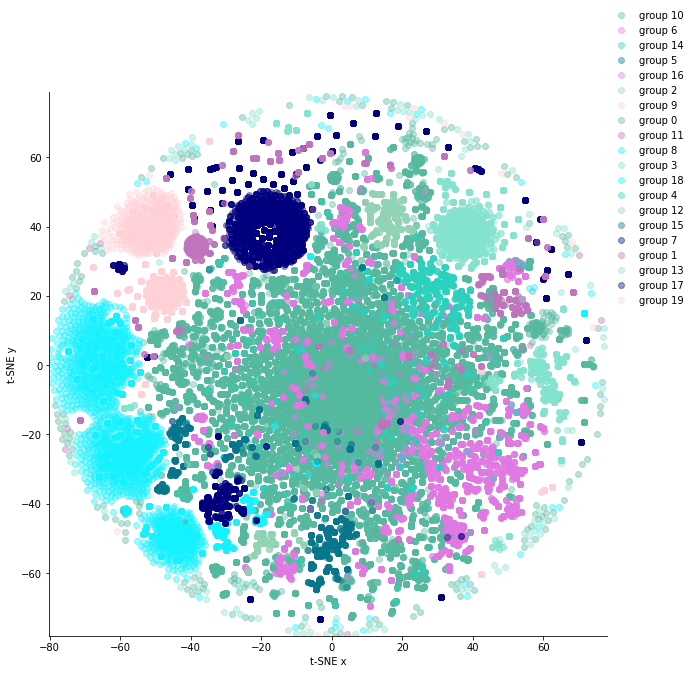

In [16]:
plt.figure(figsize=(10,10))
plt.xlim(link_tsne[:,0].min(), link_tsne[:,0].max()+1)
plt.ylim(link_tsne[:,1].min(), link_tsne[:,1].max()+1)

tsne_point_by_label = dict()

for i in range(len(concat_matrix)):
    label = labels[i]
    try:
        tsne_point_by_label[label]['x'].append(link_tsne[i, 0])
        tsne_point_by_label[label]['y'].append(link_tsne[i, 1])
    except KeyError:
        tmp_dict = {'x': [link_tsne[i, 0]], 'y': [link_tsne[i, 1]]}
        tsne_point_by_label[label] = tmp_dict


for label, coordinates in tsne_point_by_label.items():
    plt.plot(coordinates['x'], coordinates['y'], 'ro', color=by_hsv[color_names[label % 10]], label=f'group {label}')
    
plt.xlabel("t-SNE x")
plt.ylabel("t-SNE y")

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.legend(loc=(1.0, .6), frameon=False)

In [17]:
d= extract_statics_by_label(15, labels)
convert_ratio(d)

{463: {'title': '면역력을 높여보자', 'ratio': 0.08333333333333333},
 2721: {'title': '유튜버추천', 'ratio': 0.029411764705882353},
 3167: {'title': '와인안주', 'ratio': 0.03571428571428571},
 5194: {'title': '혼자 먹어도 행복한 1인 가구를 위한 레시피', 'ratio': 1.0},
 5202: {'title': '반려견 수제간식 만들기 레시피', 'ratio': 0.7222222222222222},
 5383: {'title': '프로 다이어터 다 모여라!', 'ratio': 0.05555555555555555},
 5389: {'title': '다양한 레시피 & 식이요법 모음', 'ratio': 0.7222222222222222},
 5476: {'title': "동남아의 '맛' 집에서 재현하기", 'ratio': 0.2777777777777778},
 5510: {'title': '집에서 해먹는 요리', 'ratio': 0.8333333333333334},
 5525: {'title': '다이어트를 위한 식이 레시피', 'ratio': 0.1111111111111111},
 5555: {'title': '간편하게 만들어 먹는 요리 레시피', 'ratio': 1.0},
 5577: {'title': '집에서 느긋하게..홈카페', 'ratio': 0.05555555555555555},
 5578: {'title': '초보맘을 위한 정보', 'ratio': 0.1111111111111111},
 5611: {'title': '집에서 간단히! 간편요리 레시피 모음', 'ratio': 1.0},
 5616: {'title': '[다양한 레시피]', 'ratio': 1.0},
 5637: {'title': '홈베이킹 시작하기', 'ratio': 0.3333333333333333},
 5783: {'title': '신혼밥상 레시피', 

In [18]:
d = extract_data_by_label(16, labels)
d.head(20)

,pik_id,category_id,link_id,pik_title,category_title,link_title,link_description,memo,platform,language
28,6588,14529,84411,이사할 때 알아두면 유용한 팁 모음,필수적으로 알아야 할 것들,"이사할 때 꼭 챙기세요, 장기수선충당금",[BY 부동산114] 아파트 등 공동주택에 전세나 월세로 살다가 이사 할 경우 장기...,장기수선충당금 환급 받기 #이사#장기수선충당금#아파트#관리비#시설보수,web,ko
74,6588,14529,84436,이사할 때 알아두면 유용한 팁 모음,필수적으로 알아야 할 것들,에어컨 눈탱이 방지 팁 - 보배드림 베스트글,,에어컨 이전 설치 팁 #이사#에어컨#이전설치#가스#배관,web,ko
76,6588,14529,84437,이사할 때 알아두면 유용한 팁 모음,필수적으로 알아야 할 것들,[놓치기쉬운 인테리어 팁] 이사할때 가전제품은? (가전제품 이전설치),"안녕하세요 부산 인테리어업체, 인테리어 신나라입니다. 오늘은 인테리어라고 말하긴 어...",가전제품 이전 설치 팁 #이사#가전제품#이전설치#회사서비스#A/S,web,ko
93,6588,14528,84440,이사할 때 알아두면 유용한 팁 모음,간편한 일 처리를 위해 알면 좋은 것,ktmoving 주소변경서비스,"이사, 이직으로 인한 은행,카드,보험등 번거로운 주소변경 무료로 한번에 변경하세요....",주소 변경 일괄처리 방법 #이사#주소변경#일괄처리#KT#무료,web,ko
94,6588,14528,84441,이사할 때 알아두면 유용한 팁 모음,간편한 일 처리를 위해 알면 좋은 것,청소서비스 가격비교 24번가ㅣ청소 가격비교 사이트,"청소서비스 가격비교,이사청소, 원룸청소, 입주청소비용, 이사청소비용, 청소견적, 이...",입주청소 비교 사이트 #이사#입주청소#가격비교#업체순위#무료견적,web,ko
105,6588,14529,84443,이사할 때 알아두면 유용한 팁 모음,필수적으로 알아야 할 것들,"아파트 선수관리비(선수관리비예치금, 선수예치금), 이사할 때 꼭 반환받으세요!",아파트를 입주하게 되면 관리비 외에 납부해야하는 항목들이 있습니다. 우리가 제일 많...,선수관리비 정산 #이사#아파트#선수관리비#관리사무소#반환신청,web,ko
113,6588,14528,84444,이사할 때 알아두면 유용한 팁 모음,간편한 일 처리를 위해 알면 좋은 것,국토교통부 부동산거래 전자계약시스템,"부동산 전자계약 작성 및 안내, 전자계약 현황 조회, 공동인증서 관리, 전자계약 중...",부동산 전자계약 #이사#국토교통부#직거래#수수료절약#이용률저조,web,ko
121,6588,14529,84445,이사할 때 알아두면 유용한 팁 모음,필수적으로 알아야 할 것들,남은 종량제봉투 '타지역으로 이사 가서' 사용하는법 꿀팁,남은 종량제봉투 타지역으로 이사 가서 사용하는법 꿀팁 이사갈때 타지역으로 가면 사...,남은 종량제봉투 사용하는 법 #이사#종량제봉투#타지역#주민센터#스티커,web,ko
236,6448,14508,84470,~할 때를 위한 정보 모음,핸드폰 구입할 때,휴대폰 싸게 사는 법,,휴대폰 싸게 사는 법#휴대폰구입#핸드폰싸게#핸드폰#성지#성지좌표#핸드폰구입꿀팁,web,ko
260,6448,14508,84474,~할 때를 위한 정보 모음,핸드폰 구입할 때,아이폰12 싸게 구매,,휴대폰 성지 구매 꿀팁#휴대폰구입#아이폰12#성지#구매꿀팁#꿀팁#핸드폰구매,web,ko


In [25]:
import pickle

with open('./models/c20.d1500.pkl', 'wb') as m:
    saved_model = pickle.dump(Kmeans, m)

In [29]:
with open('./models/c20.d1500.pkl', 'rb') as m:
    loaded_model = pickle.load(m)

loaded_model.predict(concat_matrix[0].reshape(1, -1))

array([10], dtype=int32)

In [59]:
stemmer.lemmatize("geese")

'goose'